In [290]:
# This project is part of the COVID-19 global hackathon
# Author: Amitabh Bhattacharya
# Student & GRA, University of North Florida, Jacksonville
# email: a.bhattacharya@unf.edu
# phone: +1 (904) 240-2777

# Importing necessary packages
import pandas as pd
import numpy as np
import scipy as sc

import math
import os
import random
from glob import glob
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import seaborn as sns
import cv2

import tensorflow as tf
import keras
from keras import layers
from keras.layers.core import Layer
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Concatenate, Reshape
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.models import load_model
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

from keras.regularizers import l2
from keras.optimizers import SGD


In [291]:
# Covid-19 and normal person's radiography images are obtained from Google dataset https://datasetsearch.research.google.com 
# Finally the images are compiled by me to fulfil the requirement.

# Image loading
train_covid_path = glob('.\\dataset\\train\\covid_19\\*')
train_normal_path = glob('.\\dataset\\train\\normal\\*')
val_covid_path = glob('.\\dataset\\val\\covid_19\\*')
val_normal_path = glob('.\\dataset\\val\\normal\\*')

X_train_temp = np.zeros((1458, 256, 256, 3))
y_train_temp = np.zeros((1458, 1))
X_val_temp = np.zeros((163, 256, 256, 3))
y_val_temp = np.zeros((163, 1))

X_train = np.zeros((1458, 256, 256, 3))
y_train = np.zeros((1458, 1))
X_val = np.zeros((163, 256, 256, 3))
y_val = np.zeros((163, 1))

# Building the training array
cnt = 0
for img_file in train_covid_path:
    image_orig = cv2.imread(img_file)
    image_resized = cv2.resize(image_orig, (256, 256), interpolation=cv2.INTER_CUBIC)
    img_array = img_to_array(image_resized)

    X_train_temp[cnt] = img_array/255
    y_train_temp[cnt] = 1
    cnt += 1

for img_file in train_normal_path:
    image_orig = cv2.imread(img_file)
    image_resized = cv2.resize(image_orig, (256, 256), interpolation=cv2.INTER_CUBIC)
    img_array = img_to_array(image_resized)

    X_train_temp[cnt] = img_array/255
    y_train_temp[cnt] = 0
    cnt += 1

# Building the validation array
cnt = 0
for img_file in val_covid_path:
    image_orig = cv2.imread(img_file)
    image_resized = cv2.resize(image_orig, (256, 256), interpolation=cv2.INTER_CUBIC)
    img_array = img_to_array(image_resized)

    X_val_temp[cnt] = img_array/255   # Normalization
    y_val_temp[cnt] = 1
    cnt += 1

for img_file in val_normal_path:
    image_orig = cv2.imread(img_file)
    image_resized = cv2.resize(image_orig, (256, 256), interpolation=cv2.INTER_CUBIC)
    img_array = img_to_array(image_resized)

    X_val_temp[cnt] = img_array/255   # Normalization
    y_val_temp[cnt] = 0
    cnt += 1


In [292]:
# Suffling the train and validation array

num_list1 = [x for x in range(0, 1458)]
num_list2 = [x for x in range(0, 163)]

random.shuffle(num_list1)
random.shuffle(num_list2)

for ind, num in enumerate(num_list1):
    X_train[ind] = X_train_temp[num]
    y_train[ind] = y_train_temp[num]
    
for ind, num in enumerate(num_list2):
    X_val[ind] = X_val_temp[num]
    y_val[ind] = y_val_temp[num]
    

Label for the image is(1 is Covid and 0 is normal):  [0.]


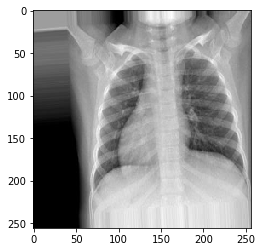

In [293]:
# Converting an array to the image and displaying it

num = random.randint(0, 1458)
temp_img = array_to_img(X_train[num])
plt.imshow(temp_img)
print("Label for the image is(1 is Covid and 0 is normal): ", y_train[num])


In [294]:
# COVID19 simple model

def Covid19_simple_model(input_shape):
# def Covid19Model(input_shape):
    """
    Implementation of the COVID19Model.
    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    
    Returns:
    model -- a Model() instance in Keras
    
    """
    
    X_train = Input(input_shape)
    
    X = ZeroPadding2D((3,3))(X_train)
    
    X = Conv2D(8, (7,7), strides=(1,1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name='max-pool0')(X)
    
    print(X.shape)
    
    X = Flatten()(X)
    
    # X = Dense(20, activation='relu', name='dense0')(X)  # Amitabh added this dense layer
    X = Dense(1, activation='sigmoid', name='fc')(X)
    
    model = Model(inputs=X_train, outputs=X, name='COVID19Model')
       
    return model


In [295]:
# COVID19 model GoogleNet (Inception v1) model

def COVID19Model(input_shape):
    # creates a model conceptually similar to the GoogLeNet (Inception v1 model)
    # The model is a modified version of GoogleNet published by Joe Marino in github code - https://gist.github.com/joelouismarino/a2ede9ab3928f999575423b9887abd14
    
    input = Input(input_shape)

    input_pad = ZeroPadding2D(padding=(3, 3))(input)
    conv1_7x7_s2 = Conv2D(64, (7,7), strides=(2,2), padding='valid', activation='relu', name='conv1/7x7_s2', kernel_regularizer=l2(0.0002))(input_pad)
    conv1_zero_pad = ZeroPadding2D(padding=(1, 1))(conv1_7x7_s2)    
    pool1_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool1/3x3_s2')(conv1_zero_pad)
    pool1_norm1 = BatchNormalization(axis=3, name='pool1/bnorm1')(pool1_3x3_s2)
    
    conv2_3x3_reduce = Conv2D(64, (1,1), padding='same', activation='relu', name='conv2/3x3_reduce', kernel_regularizer=l2(0.0002))(pool1_norm1)
    conv2_3x3 = Conv2D(192, (3,3), padding='same', activation='relu', name='conv2/3x3', kernel_regularizer=l2(0.0002))(conv2_3x3_reduce)
    conv2_norm2 = BatchNormalization(axis=3, name='conv2/bnorm2')(conv2_3x3)    
    conv2_zero_pad = ZeroPadding2D(padding=(1, 1))(conv2_norm2)
    pool2_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool2/3x3_s2')(conv2_zero_pad)

    inception_3a_1x1 = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_3a/1x1', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_3x3_reduce = Conv2D(96, (1,1), padding='same', activation='relu', name='inception_3a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3_reduce)
    inception_3a_3x3 = Conv2D(128, (3,3), padding='valid', activation='relu', name='inception_3a/3x3', kernel_regularizer=l2(0.0002))(inception_3a_3x3_pad)
    inception_3a_5x5_reduce = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_3a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5_reduce)
    inception_3a_5x5 = Conv2D(32, (5,5), padding='valid', activation='relu', name='inception_3a/5x5', kernel_regularizer=l2(0.0002))(inception_3a_5x5_pad)
    inception_3a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_3a/pool')(pool2_3x3_s2)
    inception_3a_pool_proj = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_3a/pool_proj', kernel_regularizer=l2(0.0002))(inception_3a_pool)
    inception_3a_output = Concatenate(axis=-1, name='inception_3a/output')([inception_3a_1x1,inception_3a_3x3,inception_3a_5x5,inception_3a_pool_proj])

    inception_3b_1x1 = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_3b/1x1', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_3x3_reduce = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_3b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3_reduce)
    inception_3b_3x3 = Conv2D(192, (3,3), padding='valid', activation='relu', name='inception_3b/3x3', kernel_regularizer=l2(0.0002))(inception_3b_3x3_pad)
    inception_3b_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_3b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5_reduce)
    inception_3b_5x5 = Conv2D(96, (5,5), padding='valid', activation='relu', name='inception_3b/5x5', kernel_regularizer=l2(0.0002))(inception_3b_5x5_pad)
    inception_3b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_3b/pool')(inception_3a_output)
    inception_3b_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_3b/pool_proj', kernel_regularizer=l2(0.0002))(inception_3b_pool)
    inception_3b_output = Concatenate(axis=-1, name='inception_3b/output')([inception_3b_1x1,inception_3b_3x3,inception_3b_5x5,inception_3b_pool_proj])

    inception_3b_output_zero_pad = ZeroPadding2D(padding=(1, 1))(inception_3b_output)
    pool3_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool3/3x3_s2')(inception_3b_output_zero_pad)

    inception_4a_1x1 = Conv2D(192, (1,1), padding='same', activation='relu', name='inception_4a/1x1', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_3x3_reduce = Conv2D(96, (1,1), padding='same', activation='relu', name='inception_4a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4a_3x3_reduce)
    inception_4a_3x3 = Conv2D(208, (3,3), padding='valid', activation='relu', name='inception_4a/3x3' ,kernel_regularizer=l2(0.0002))(inception_4a_3x3_pad)
    inception_4a_5x5_reduce = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_4a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4a_5x5_reduce)
    inception_4a_5x5 = Conv2D(48, (5,5), padding='valid', activation='relu', name='inception_4a/5x5', kernel_regularizer=l2(0.0002))(inception_4a_5x5_pad)
    inception_4a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4a/pool')(pool3_3x3_s2)
    inception_4a_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4a/pool_proj', kernel_regularizer=l2(0.0002))(inception_4a_pool)
    inception_4a_output = Concatenate(axis=-1, name='inception_4a/output')([inception_4a_1x1,inception_4a_3x3,inception_4a_5x5,inception_4a_pool_proj])

    loss1_ave_pool = AveragePooling2D(pool_size=(5,5), strides=(3,3), name='loss1/ave_pool')(inception_4a_output)
    loss1_conv = Conv2D(128, (1,1), padding='same', activation='relu', name='loss1/conv', kernel_regularizer=l2(0.0002))(loss1_ave_pool)
    loss1_flat = Flatten()(loss1_conv)
    loss1_fc = Dense(1024, activation='relu', name='loss1/fc', kernel_regularizer=l2(0.0002))(loss1_flat)
    loss1_drop_fc = Dropout(rate=0.25)(loss1_fc)
    loss1_classifier = Dense(1, name='loss1/classifier', kernel_regularizer=l2(0.0002))(loss1_drop_fc)
    loss1_classifier_act = Activation('sigmoid')(loss1_classifier)
    
    inception_4b_1x1 = Conv2D(160, (1,1), padding='same', activation='relu', name='inception_4b/1x1', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_3x3_reduce = Conv2D(112, (1,1), padding='same', activation='relu', name='inception_4b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4b_3x3_reduce)
    inception_4b_3x3 = Conv2D(224, (3,3), padding='valid', activation='relu', name='inception_4b/3x3', kernel_regularizer=l2(0.0002))(inception_4b_3x3_pad)
    inception_4b_5x5_reduce = Conv2D(24, (1,1), padding='same', activation='relu', name='inception_4b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4b_5x5_reduce)
    inception_4b_5x5 = Conv2D(64, (5,5), padding='valid', activation='relu', name='inception_4b/5x5', kernel_regularizer=l2(0.0002))(inception_4b_5x5_pad)
    inception_4b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4b/pool')(inception_4a_output)
    inception_4b_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4b/pool_proj', kernel_regularizer=l2(0.0002))(inception_4b_pool)
    inception_4b_output = Concatenate(axis=-1, name='inception_4b/output')([inception_4b_1x1,inception_4b_3x3,inception_4b_5x5,inception_4b_pool_proj])

    inception_4c_1x1 = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_4c/1x1', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_3x3_reduce = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_4c/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4c_3x3_reduce)
    inception_4c_3x3 = Conv2D(256, (3,3), padding='valid', activation='relu', name='inception_4c/3x3', kernel_regularizer=l2(0.0002))(inception_4c_3x3_pad)
    inception_4c_5x5_reduce = Conv2D(24, (1,1), padding='same', activation='relu', name='inception_4c/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4c_5x5_reduce)
    inception_4c_5x5 = Conv2D(64, (5,5), padding='valid', activation='relu', name='inception_4c/5x5', kernel_regularizer=l2(0.0002))(inception_4c_5x5_pad)
    inception_4c_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4c/pool')(inception_4b_output)
    inception_4c_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4c/pool_proj', kernel_regularizer=l2(0.0002))(inception_4c_pool)
    inception_4c_output = Concatenate(axis=-1, name='inception_4c/output')([inception_4c_1x1,inception_4c_3x3,inception_4c_5x5,inception_4c_pool_proj])

    inception_4d_1x1 = Conv2D(112, (1,1), padding='same', activation='relu', name='inception_4d/1x1', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_3x3_reduce = Conv2D(144, (1,1), padding='same', activation='relu', name='inception_4d/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4d_3x3_reduce)
    inception_4d_3x3 = Conv2D(288, (3,3), padding='valid', activation='relu', name='inception_4d/3x3', kernel_regularizer=l2(0.0002))(inception_4d_3x3_pad)
    inception_4d_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_4d/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4d_5x5_reduce)
    inception_4d_5x5 = Conv2D(64, (5,5), padding='valid', activation='relu', name='inception_4d/5x5', kernel_regularizer=l2(0.0002))(inception_4d_5x5_pad)
    inception_4d_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4d/pool')(inception_4c_output)
    inception_4d_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4d/pool_proj', kernel_regularizer=l2(0.0002))(inception_4d_pool)
    inception_4d_output = Concatenate(axis=-1, name='inception_4d/output')([inception_4d_1x1,inception_4d_3x3,inception_4d_5x5,inception_4d_pool_proj])

    loss2_ave_pool = AveragePooling2D(pool_size=(5,5), strides=(3,3), name='loss2/ave_pool')(inception_4d_output)
    loss2_conv = Conv2D(128, (1,1), padding='same', activation='relu', name='loss2/conv', kernel_regularizer=l2(0.0002))(loss2_ave_pool)
    loss2_flat = Flatten()(loss2_conv)
    loss2_fc = Dense(1024, activation='relu', name='loss2/fc', kernel_regularizer=l2(0.0002))(loss2_flat)
    loss2_drop_fc = Dropout(rate=0.25)(loss2_fc)
    loss2_classifier = Dense(1, name='loss2/classifier', kernel_regularizer=l2(0.0002))(loss2_drop_fc)
    loss2_classifier_act = Activation('sigmoid')(loss2_classifier)
    
    inception_4e_1x1 = Conv2D(256, (1,1), padding='same', activation='relu', name='inception_4e/1x1', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_3x3_reduce = Conv2D(160, (1,1), padding='same', activation='relu', name='inception_4e/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4e_3x3_reduce)
    inception_4e_3x3 = Conv2D(320, (3,3), padding='valid', activation='relu', name='inception_4e/3x3', kernel_regularizer=l2(0.0002))(inception_4e_3x3_pad)
    inception_4e_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_4e/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4e_5x5_reduce)
    inception_4e_5x5 = Conv2D(128, (5,5), padding='valid', activation='relu', name='inception_4e/5x5', kernel_regularizer=l2(0.0002))(inception_4e_5x5_pad)
    inception_4e_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4e/pool')(inception_4d_output)
    inception_4e_pool_proj = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_4e/pool_proj', kernel_regularizer=l2(0.0002))(inception_4e_pool)
    inception_4e_output = Concatenate(axis=-1, name='inception_4e/output')([inception_4e_1x1,inception_4e_3x3,inception_4e_5x5,inception_4e_pool_proj])

    inception_4e_output_zero_pad = ZeroPadding2D(padding=(1, 1))(inception_4e_output)    
    pool4_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool4/3x3_s2')(inception_4e_output_zero_pad)

    inception_5a_1x1 = Conv2D(256, (1,1), padding='same', activation='relu', name='inception_5a/1x1', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_3x3_reduce = Conv2D(160, (1,1), padding='same', activation='relu', name='inception_5a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_5a_3x3_reduce)
    inception_5a_3x3 = Conv2D(320, (3,3), padding='valid', activation='relu', name='inception_5a/3x3', kernel_regularizer=l2(0.0002))(inception_5a_3x3_pad)
    inception_5a_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_5a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_5a_5x5_reduce)
    inception_5a_5x5 = Conv2D(128, (5,5), padding='valid', activation='relu', name='inception_5a/5x5', kernel_regularizer=l2(0.0002))(inception_5a_5x5_pad)
    inception_5a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_5a/pool')(pool4_3x3_s2)
    inception_5a_pool_proj = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_5a/pool_proj', kernel_regularizer=l2(0.0002))(inception_5a_pool)
    inception_5a_output = Concatenate(axis=-1, name='inception_5a/output')([inception_5a_1x1,inception_5a_3x3,inception_5a_5x5,inception_5a_pool_proj])

    inception_5b_1x1 = Conv2D(384, (1,1), padding='same', activation='relu', name='inception_5b/1x1', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_3x3_reduce = Conv2D(192, (1,1), padding='same', activation='relu', name='inception_5b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_5b_3x3_reduce)
    inception_5b_3x3 = Conv2D(384, (3,3), padding='valid', activation='relu', name='inception_5b/3x3', kernel_regularizer=l2(0.0002))(inception_5b_3x3_pad)
    inception_5b_5x5_reduce = Conv2D(48, (1,1), padding='same', activation='relu', name='inception_5b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_5b_5x5_reduce)
    inception_5b_5x5 = Conv2D(128, (5,5), padding='valid', activation='relu', name='inception_5b/5x5', kernel_regularizer=l2(0.0002))(inception_5b_5x5_pad)
    inception_5b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_5b/pool')(inception_5a_output)
    inception_5b_pool_proj = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_5b/pool_proj', kernel_regularizer=l2(0.0002))(inception_5b_pool)
    inception_5b_output = Concatenate(axis=-1, name='inception_5b/output')([inception_5b_1x1,inception_5b_3x3,inception_5b_5x5,inception_5b_pool_proj])

    pool5_7x7_s1 = AveragePooling2D(pool_size=(7,7), strides=(1,1), name='pool5/7x7_s2')(inception_5b_output)
    loss3_flat = Flatten()(pool5_7x7_s1)
    pool5_drop_7x7_s1 = Dropout(rate=0.25)(loss3_flat)
    loss3_classifier = Dense(1, name='loss3/classifier', kernel_regularizer=l2(0.0002))(pool5_drop_7x7_s1)
    loss3_classifier_act = Activation('sigmoid', name='prob')(loss3_classifier)
        
    googlenet_covid19_model = Model(inputs=input, outputs=loss3_classifier_act) 
   
    return googlenet_covid19_model


In [296]:
# Creation/Compiling/Training the model

covid19Model = COVID19Model(X_train.shape[1:])
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
covid19Model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])
covid19Model.fit(X_train, y_train, batch_size = 100, epochs = 5, verbose = 1)


Epoch 1/5
1458/1458 [==============================] - 392s 269ms/step - loss: 2.1499 - accuracy: 0.8155
Epoch 2/5
1458/1458 [==============================] - 368s 252ms/step - loss: 1.9655 - accuracy: 0.8512
Epoch 3/5
1458/1458 [==============================] - 392s 269ms/step - loss: 1.9987 - accuracy: 0.8086
Epoch 4/5
1458/1458 [==============================] - 383s 263ms/step - loss: 1.8818 - accuracy: 0.8512
Epoch 5/5
1458/1458 [==============================] - 295s 202ms/step - loss: 1.8737 - accuracy: 0.8834


Label for the image is(1 is Covid and 0 is normal):  [0.]
Sum of y_train:  [217.]
Sum of y_train:  [25.]


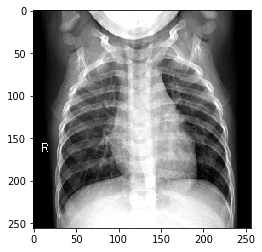

In [297]:
# Casual test
temp_img = array_to_img(X_train[1457])
plt.imshow(temp_img)
print("Label for the image is(1 is Covid and 0 is normal): ", y_train[1457])
print("Sum of y_train: ", sum(y_train))
print("Sum of y_train: ", sum(y_val))


In [298]:
# Model performance evaluation

preds = covid19Model.evaluate(X_val, y_val)
# preds = covid19Model.evaluate(X_train, y_train)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))


163/163 [==============================] - 9s 57ms/step
Loss = 1.9882451566450434
Test Accuracy = 0.9141104221343994


In [299]:
# Summary of COVID19 model
covid19Model.summary()


Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_565 (ZeroPadding (None, 262, 262, 3)  0           input_43[0][0]                   
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 128, 128, 64) 9472        zero_padding2d_565[0][0]         
__________________________________________________________________________________________________
zero_padding2d_566 (ZeroPadding (None, 130, 130, 64) 0           conv1/7x7_s2[0][0]               
___________________________________________________________________________________________

Test image prediction(1 is Covid and 0 is normal):  [[0.2537144]]
Test image ground truth:  [0.]


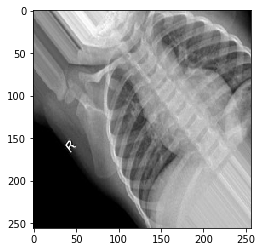

In [300]:
# Predict from the COVID19 model

# Save the model for future use
covid19Model.save('C:\\Users\\amitabh_suja\\Desktop\\COVID_19\\covid19Model')

# Load the earlier saved COVID19 model
saved_covid19Model = load_model('C:\\Users\\amitabh_suja\\Desktop\\COVID_19\\covid19Model')

"""
test_img_file = ""
test_img_orig = cv2.imread(test_img_file)
test_img_resized = cv2.resize(test_img_orig, (256, 256), interpolation=cv2.INTER_CUBIC)
test_img_array = img_to_array(test_img_resized)
test_img_array = test_img_array/255

plt.imshow(test_img_orig)
print("Test image prediction(1 is Covid and 0 is normal): ", saved_covid19Model.predict(test_img_array))

"""

num = random.randint(0, 163)
test_img = array_to_img(X_val[num])

test_input = np.expand_dims(X_val[num], axis=0)
plt.imshow(test_img)
print("Test image prediction(1 is Covid and 0 is normal): ", saved_covid19Model.predict(test_input))
print("Test image ground truth: ", y_val[num])


Test image prediction(1 is Covid and 0 is normal):  [[0.17798166]]
Test image ground truth:  [0.]


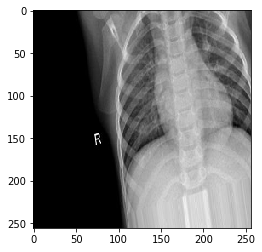

In [301]:
# Prediction
num = random.randint(0, 163)
test_img = array_to_img(X_val[num])

test_input = np.expand_dims(X_val[num], axis=0)
plt.imshow(test_img)
print("Test image prediction(1 is Covid and 0 is normal): ", saved_covid19Model.predict(test_input))
print("Test image ground truth: ", y_val[num])
